In [3]:
from schemes import * 
from utils import *
from fourier import *

from tqdm import tqdm 
import time 

### I. TG(-M) scheme 

In [34]:
V0, a, b, c, rho = 0.006, 17.25*0.018, -17.25, 2.95, -0.68 
S0 = 100
alpha = 5 

psi_values, f_mu_values, f_sigma_values = get_f_mu_sigma_grids(a, c, alpha=5, tilde_N=1000)

In [36]:
n_range = np.linspace(1, 100, 10, dtype=int)
M = 1*int(1e6)

N_values = []
eta_values = [] 

for n in tqdm(n_range) : 
    N_values.append(simulate_antithetic(M, n))
    eta_values.append(np.random.uniform(size=(M, n)))

T = 1 

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


In [38]:
TG_M_price_1_ITM, TG_price_1_ITM = np.zeros(len(n_range)), np.zeros(len(n_range))
TG_M_price_1_ATM, TG_price_1_ATM = np.zeros(len(n_range)), np.zeros(len(n_range))
TG_M_price_1_OTM, TG_price_1_OTM = np.zeros(len(n_range)), np.zeros(len(n_range))

TG_M_time_1_ITM, TG_time_1_ITM = np.zeros(len(n_range)), np.zeros(len(n_range))
TG_M_time_1_ATM, TG_time_1_ATM = np.zeros(len(n_range)), np.zeros(len(n_range))
TG_M_time_1_OTM, TG_time_1_OTM = np.zeros(len(n_range)), np.zeros(len(n_range))

for i, n in enumerate(tqdm(n_range)) :
    start = time.time() 
    S, V = simulate_TG(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], alpha, f_mu_values, f_sigma_values)
    common_TG = time.time()-start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_price_1_ATM[i] = mean
    TG_time_1_ATM[i] = time.time() - start + common_TG 
    if i == len(n_range)-1 : 
        TG_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_price_1_ITM[i] = mean
    TG_time_1_ITM[i] = time.time() - start + common_TG 
    if i == len(n_range)-1 : 
        TG_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_price_1_OTM[i] = mean
    TG_time_1_OTM[i] = time.time() - start + common_TG 
    if i == len(n_range)-1 :
        TG_3_std_price_1_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_TG_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i], alpha, f_mu_values, f_sigma_values)
    common_TG_M = time.time()-start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    TG_M_price_1_ATM[i] = mean
    TG_M_time_1_ATM[i] = time.time() - start + common_TG_M 
    if i == len(n_range)-1 : 
        TG_M_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    TG_M_price_1_ITM[i] = mean
    TG_M_time_1_ITM[i] = time.time() - start + common_TG_M 
    if i == len(n_range)-1 : 
        TG_M_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    TG_M_price_1_OTM[i] = mean
    TG_M_time_1_OTM[i] = time.time() - start + common_TG_M 
    if i == len(n_range)-1 :
        TG_M_3_std_price_1_OTM = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.57s/it]


In [40]:
true_price_1_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_1_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_1_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_1_ITM, true_price_1_ATM, true_price_1_OTM

(40.1162938845335, 4.345385427983771, 0.0014843170361160674)

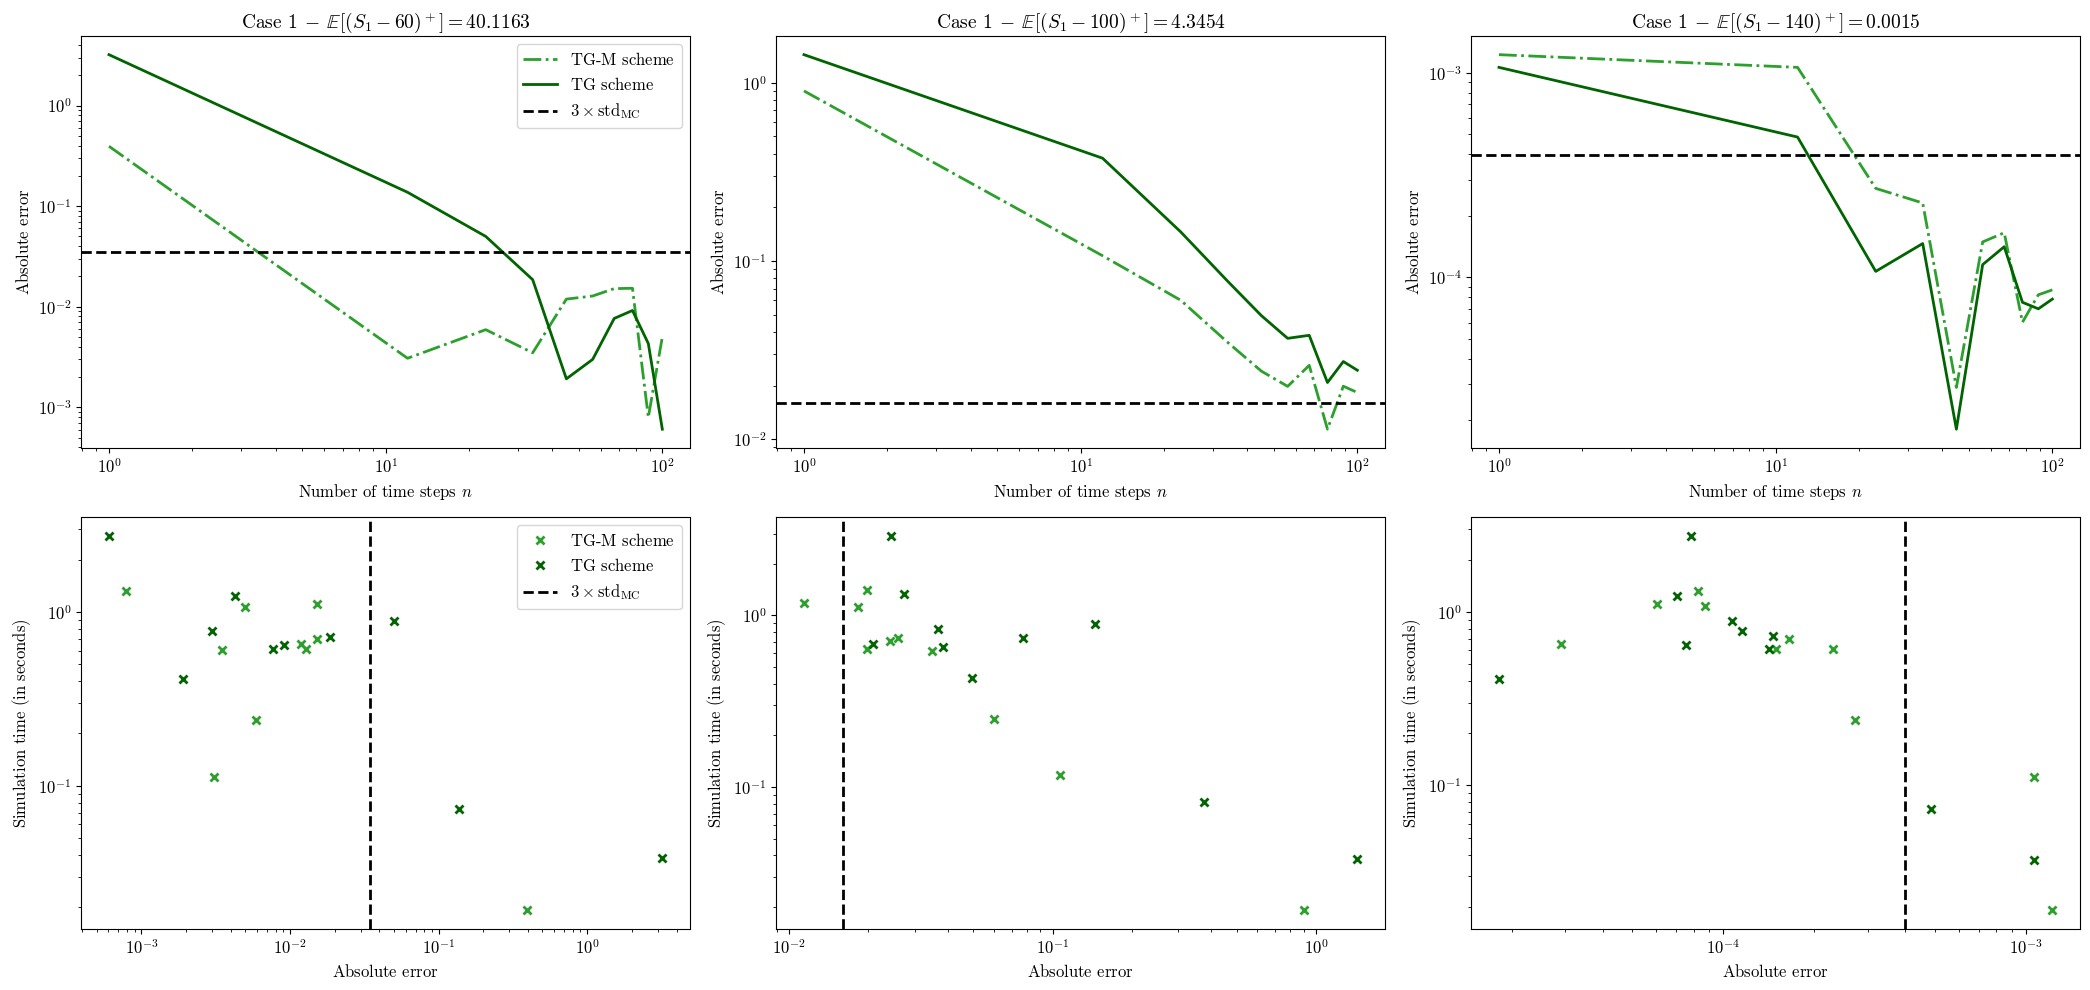

In [73]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

ax[0].loglog(n_range, np.abs(true_price_1_ITM - TG_M_price_1_ITM), lw=2, linestyle="-.", color="tab:green", label=r"$\text{TG-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_1_ITM - TG_price_1_ITM), lw=2, color="darkgreen", label=r"$\text{TG scheme}$")
ax[0].axhline(TG_3_std_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-60)^+] = 40.1163$", fontsize=14)

ax[1].loglog(n_range, np.abs(true_price_1_ATM - TG_M_price_1_ATM), lw=2, linestyle="-.", color="tab:green", label=r"$\text{TG-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_1_ATM - TG_price_1_ATM), lw=2, color="darkgreen", label=r"$\text{TG scheme}$")
ax[1].axhline(TG_3_std_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-100)^+] = 4.3454$", fontsize=14)

ax[2].loglog(n_range, np.abs(true_price_1_OTM - TG_M_price_1_OTM), lw=2, linestyle="-.", color="tab:green", label=r"$\text{TG-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_1_OTM - TG_price_1_OTM), lw=2, color="darkgreen", label=r"$\text{TG scheme}$")
ax[2].axhline(TG_3_std_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-140)^+] = 0.0015$", fontsize=14)

ax[3].loglog(np.abs(true_price_1_ITM - TG_M_price_1_ITM)[::-1], TG_M_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[3].loglog(np.abs(true_price_1_ITM - TG_price_1_ITM)[::-1], TG_time_1_ITM[::-1], "x", markeredgewidth=2, color="darkgreen", label=r"$\text{TG scheme}$")
ax[3].axvline(TG_3_std_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[4].loglog(np.abs(true_price_1_ATM - TG_M_price_1_ATM)[::-1], TG_M_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[4].loglog(np.abs(true_price_1_ATM - TG_price_1_ATM)[::-1], TG_time_1_ATM[::-1], "x", markeredgewidth=2, color="darkgreen", label=r"$\text{TG scheme}$")
ax[4].axvline(TG_3_std_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[5].loglog(np.abs(true_price_1_OTM - TG_M_price_1_OTM)[::-1], TG_M_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:green", label=r"$\text{TG-M scheme}$")
ax[5].loglog(np.abs(true_price_1_OTM - TG_price_1_OTM)[::-1], TG_time_1_OTM[::-1], "x", markeredgewidth=2, color="darkgreen", label=r"$\text{TG scheme}$")
ax[5].axvline(TG_3_std_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")


for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    
for i in range(3, 6) : 
    ax[i].set_xlabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Simulation time (in seconds)}$", fontsize=12)

for i in range(6) : 
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].legend(loc="upper right", fontsize=12)
ax[3].legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

### II. QE(-M) scheme 

In [75]:
V0, a, b, c, rho = 0.006, 17.25*0.018, -17.25, 2.95, -0.68 
S0 = 100

In [77]:
n_range = np.linspace(1, 100, 10, dtype=int)
M = 1*int(1e6)

N_values = []
eta_values = [] 

for n in tqdm(n_range) : 
    N_values.append(simulate_antithetic(M, n))
    eta_values.append(np.random.uniform(size=(M, n)))

T = 1 

100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


In [79]:
QE_M_price_1_ITM, QE_price_1_ITM = np.zeros(len(n_range)), np.zeros(len(n_range))
QE_M_price_1_ATM, QE_price_1_ATM = np.zeros(len(n_range)), np.zeros(len(n_range))
QE_M_price_1_OTM, QE_price_1_OTM = np.zeros(len(n_range)), np.zeros(len(n_range))

QE_M_time_1_ITM, QE_time_1_ITM = np.zeros(len(n_range)), np.zeros(len(n_range))
QE_M_time_1_ATM, QE_time_1_ATM = np.zeros(len(n_range)), np.zeros(len(n_range))
QE_M_time_1_OTM, QE_time_1_OTM = np.zeros(len(n_range)), np.zeros(len(n_range))

for i, n in enumerate(tqdm(n_range)) :
    start = time.time() 
    S, V = simulate_QE(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i])
    common_QE = time.time()-start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_price_1_ATM[i] = mean
    QE_time_1_ATM[i] = time.time() - start + common_QE 
    if i == len(n_range)-1 : 
        QE_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_price_1_ITM[i] = mean
    QE_time_1_ITM[i] = time.time() - start + common_QE 
    if i == len(n_range)-1 : 
        QE_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_price_1_OTM[i] = mean
    QE_time_1_OTM[i] = time.time() - start + common_QE 
    if i == len(n_range)-1 :
        QE_3_std_price_1_OTM = 3 * np.sqrt(var/M)

    start = time.time() 
    S, V = simulate_QE_M(T, S0, V0, a, b, c, rho, N_values[i], eta_values[i])
    common_QE_M = time.time()-start 

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 100, 0.0))
    QE_M_price_1_ATM[i] = mean
    QE_M_time_1_ATM[i] = time.time() - start + common_QE_M 
    if i == len(n_range)-1 : 
        QE_M_3_std_price_1_ATM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 60, 0.0))
    QE_M_price_1_ITM[i] = mean
    QE_M_time_1_ITM[i] = time.time() - start + common_QE_M 
    if i == len(n_range)-1 : 
        QE_M_3_std_price_1_ITM = 3 * np.sqrt(var/M)

    start = time.time() 
    mean, var, _, _ = monte_carlo(np.maximum(S[:, -1] - 140, 0.0))
    QE_M_price_1_OTM[i] = mean
    QE_M_time_1_OTM[i] = time.time() - start + common_QE_M 
    if i == len(n_range)-1 :
        QE_M_3_std_price_1_OTM = 3 * np.sqrt(var/M)

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.10s/it]


In [83]:
true_price_1_ITM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 60, 150, flag="call")
true_price_1_ATM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 100, 150, flag="call")
true_price_1_OTM = compute_europ_Fourier_Heston(T, S0, V0, a, b, c, rho, 140, 150, flag="call")
true_price_1_ITM, true_price_1_ATM, true_price_1_OTM

(40.1162938845335, 4.345385427983771, 0.0014843170361160674)

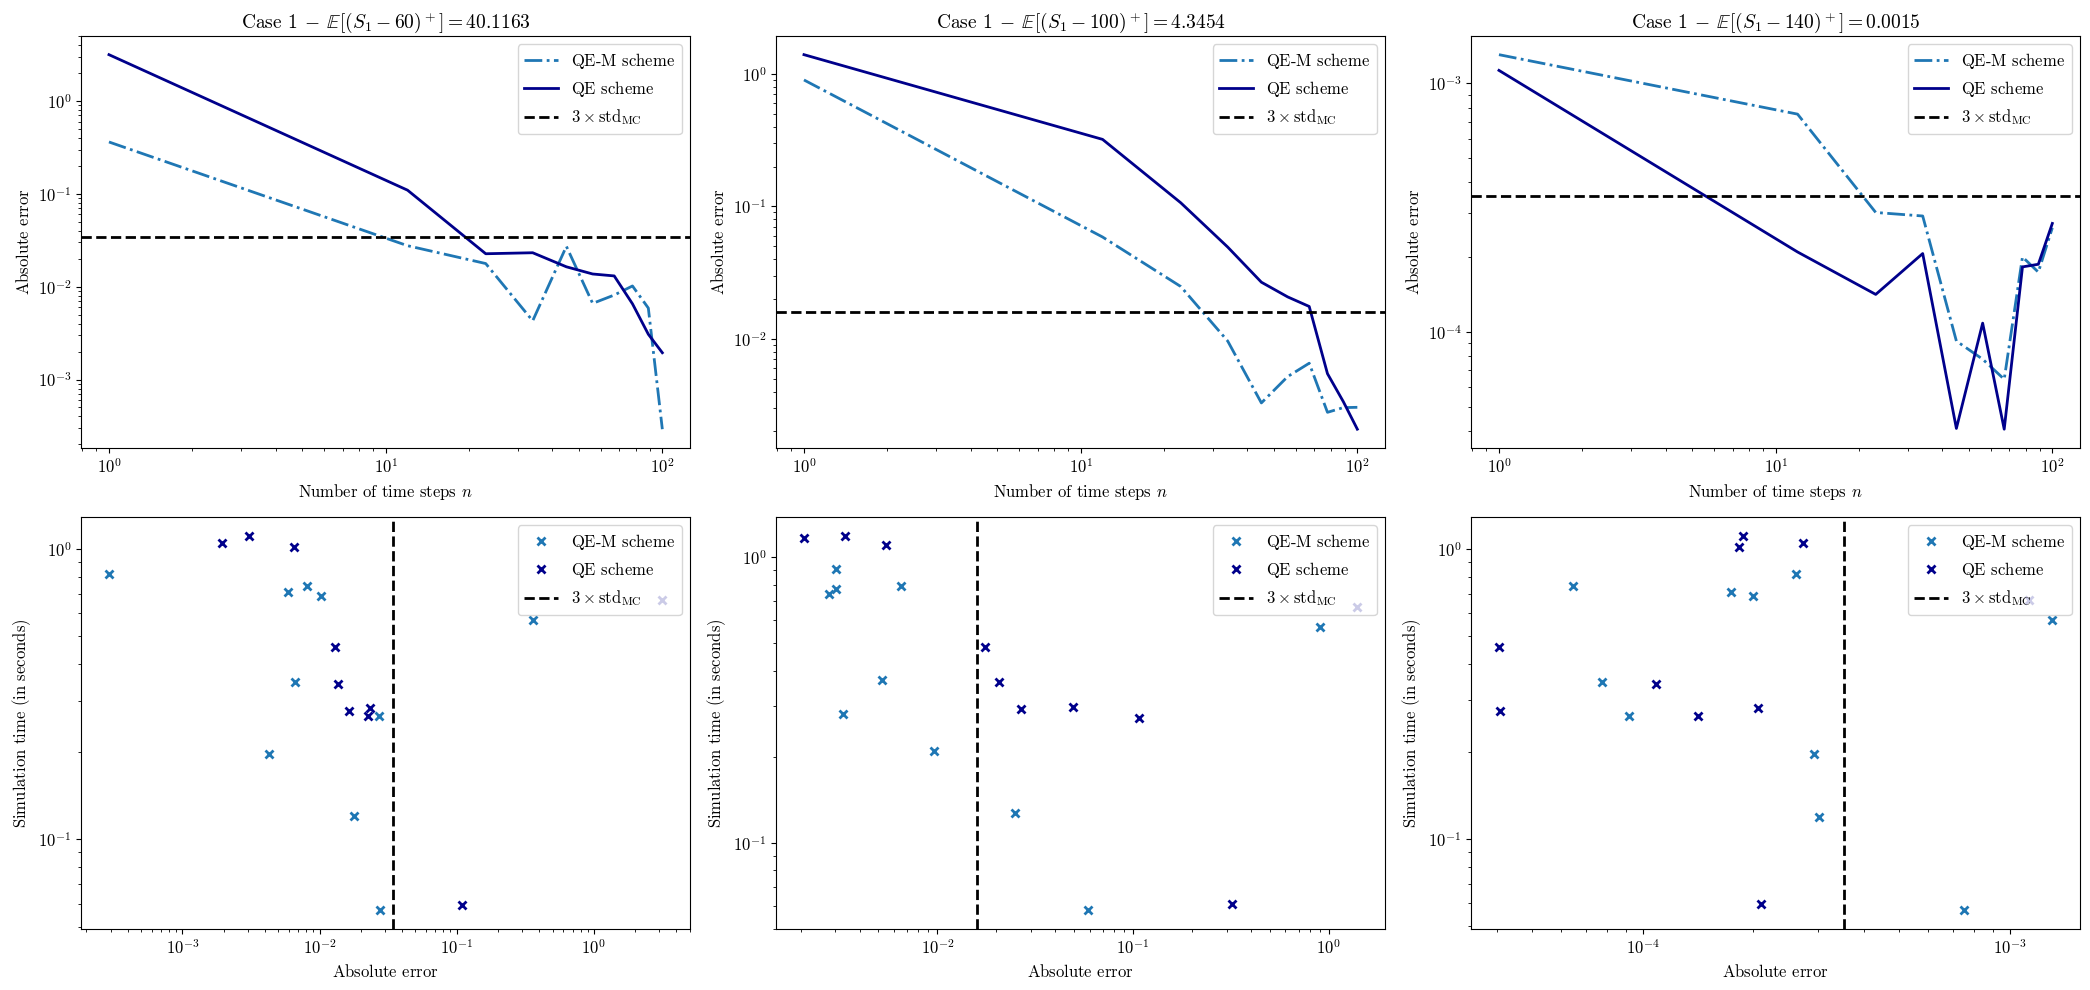

In [97]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
ax = ax.flatten()

ax[0].loglog(n_range, np.abs(true_price_1_ITM - QE_M_price_1_ITM), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[0].loglog(n_range, np.abs(true_price_1_ITM - QE_price_1_ITM), lw=2, color="darkblue", label=r"$\text{QE scheme}$")
ax[0].axhline(QE_3_std_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[0].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-60)^+] = 40.1163$", fontsize=14)

ax[1].loglog(n_range, np.abs(true_price_1_ATM - QE_M_price_1_ATM), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[1].loglog(n_range, np.abs(true_price_1_ATM - QE_price_1_ATM), lw=2, color="darkblue", label=r"$\text{QE scheme}$")
ax[1].axhline(QE_3_std_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[1].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-100)^+] = 4.3454$", fontsize=14)

ax[2].loglog(n_range, np.abs(true_price_1_OTM - QE_M_price_1_OTM), lw=2, linestyle="-.", color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[2].loglog(n_range, np.abs(true_price_1_OTM - QE_price_1_OTM), lw=2, color="darkblue", label=r"$\text{QE scheme}$")
ax[2].axhline(QE_3_std_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")
ax[2].set_title(r"$\text{Case 1}\:-\:\mathbb{E}[(S_1-140)^+] = 0.0015$", fontsize=14)

ax[3].loglog(np.abs(true_price_1_ITM - QE_M_price_1_ITM)[::-1], QE_M_time_1_ITM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[3].loglog(np.abs(true_price_1_ITM - QE_price_1_ITM)[::-1], QE_time_1_ITM[::-1], "x", markeredgewidth=2, color="darkblue", label=r"$\text{QE scheme}$")
ax[3].axvline(QE_3_std_price_1_ITM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[4].loglog(np.abs(true_price_1_ATM - QE_M_price_1_ATM)[::-1], QE_M_time_1_ATM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[4].loglog(np.abs(true_price_1_ATM - QE_price_1_ATM)[::-1], QE_time_1_ATM[::-1], "x", markeredgewidth=2, color="darkblue", label=r"$\text{QE scheme}$")
ax[4].axvline(QE_3_std_price_1_ATM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")

ax[5].loglog(np.abs(true_price_1_OTM - QE_M_price_1_OTM)[::-1], QE_M_time_1_OTM[::-1], "x", markeredgewidth=2, color="tab:blue", label=r"$\text{QE-M scheme}$")
ax[5].loglog(np.abs(true_price_1_OTM - QE_price_1_OTM)[::-1], QE_time_1_OTM[::-1], "x", markeredgewidth=2, color="darkblue", label=r"$\text{QE scheme}$")
ax[5].axvline(QE_3_std_price_1_OTM, lw=2, color="black", linestyle="--", label=r"$3\times\text{std}_\text{MC}$")


for i in range(3) : 
    ax[i].set_ylabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_xlabel(r"$\text{Number of time steps } n$", fontsize=12)
    
for i in range(3, 6) : 
    ax[i].set_xlabel(r"$\text{Absolute error}$", fontsize=12)
    ax[i].set_ylabel(r"$\text{Simulation time (in seconds)}$", fontsize=12)

for i in range(6) : 
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$"))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$"))
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.savefig("martingality_correction_QE.png", dpi=300, transparent=True)
plt.show()